# 02 - Data Preprocessing

**Purpose**: Clean data, encode, scale, split, and SAVE for next notebook.

**Outputs**:
- `data/processed/features_v1_train.csv`
- `data/processed/features_v1_test.csv`
- `models/scaler_v1.joblib`

In [14]:
import sys; sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [15]:
RAW_DATA_PATH = '../data/raw/cancer_endometri.csv'
PROCESSED_DATA_PATH = '../data/processed/dataset_processat.csv'
TARGET_COLUMN = 'recidiva'

SELECTED_COLUMNS = [
    'recidiva',                         # Target
    'recidiva_exitus',                  # Temporal - per corregir target
    'FIGO2023',                         # Estadiatge (Ordinal 1-14)
    'recep_est_porcent',                # Biomarcador numèric
    'afectacion_linf',                  # Binària (LVSI)
    'grado_histologi',                  # Ordinal (1=Baix, 2=Alt)
    'Reseccion_macroscopica_complet',   # Binària
    'edad',                             # Numèrica
    'imc'                               # Numèrica
]

In [26]:
# Càrrega del dataset amb NA strings convertits a NaN
df = pd.read_csv(RAW_DATA_PATH, na_values=['NA', 'Na', 'na', ''])
print(f"Dataset original: {df.shape[0]} files, {df.shape[1]} columnes")

# Selecció de columnes
df = df[SELECTED_COLUMNS].copy()
print(f"Després de selecció: {df.shape[1]} columnes")
df.head()

Dataset original: 163 files, 189 columnes
Després de selecció: 9 columnes


,recidiva,recidiva_exitus,FIGO2023,recep_est_porcent,afectacion_linf,grado_histologi,Reseccion_macroscopica_complet,edad,imc
0,0,0,14.0,80.0,NaN,2.0,NaN,68.0,39.40
1,0,0,NaN,NaN,NaN,NaN,NaN,92.0,24.14
2,0,0,1.0,NaN,1.0,1.0,NaN,72.0,38.80
3,1,1,11.0,90.0,1.0,1.0,NaN,78.0,36.30
4,0,0,1.0,90.0,0.0,1.0,NaN,68.0,31.10


In [ ]:

df['recidiva'] = pd.to_numeric(df['recidiva'], errors='coerce')
df['recidiva_exitus'] = pd.to_numeric(df['recidiva_exitus'], errors='coerce')

mask = (df['recidiva'] == 0) & (df['recidiva_exitus'] == 1)
n_corrected = mask.sum()
df.loc[mask, 'recidiva'] = 1
print(f"✅ Corregits {n_corrected} casos (recidiva=0 però recidiva_exitus=1)")

df = df.drop(columns=['recidiva_exitus'])

✅ Corregits 5 casos (recidiva=0 però recidiva_exitus=1)


In [28]:
# Elimina 2 i NA de la target
initial_rows = df.shape[0]
df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')
df = df[df[TARGET_COLUMN].isin([0, 1])].copy()
df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(int)

print(f"Eliminades {initial_rows - df.shape[0]} files (recidiva=2 o NA)")
print(f"Files restants: {df.shape[0]}")
print(df[TARGET_COLUMN].value_counts())

Eliminades 9 files (recidiva=2 o NA)
Files restants: 154
recidiva
0    120
1     34
Name: count, dtype: int64


In [20]:
# Convertir totes les columnes a numèric
numeric_cols = ['recep_est_porcent', 'edad', 'imc', 'grado_histologi',
                'afectacion_linf', 'Reseccion_macroscopica_complet', 'FIGO2023']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verificar nuls abans d'imputar
print("Nuls per columna:")
print(df.isnull().sum())

Nuls per columna:
recidiva                            0
FIGO2023                           18
recep_est_porcent                  67
afectacion_linf                    16
grado_histologi                    15
Reseccion_macroscopica_complet    127
edad                                0
imc                                 6
dtype: int64


In [ ]:
# Imputació amb MITJANA per variables contínues
for col in ['recep_est_porcent', 'edad']:
    if df[col].isna().sum() > 0:
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
        print(f"{col}: imputat amb mitjana ({mean_val:.2f})")

if df['imc'].isna().sum() > 0:
    median_val = df['imc'].median()
    df['imc'] = df['imc'].fillna(median_val)
    print(f"IMC: Imputat amb mediana ({median_val:.2f})")

# Imputació amb MODA per variables ordinals/binàries
for col in ['FIGO2023', 'afectacion_linf', 'grado_histologi', 'Reseccion_macroscopica_complet']:
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 0
        df[col] = df[col].fillna(mode_val)
        print(f"{col}: imputat amb moda ({mode_val})")

print("\n✅ Imputació completada")
print("Nuls restants:", df.isnull().sum().sum())

recep_est_porcent: imputat amb mitjana (76.28)
imc: imputat amb mitjana (30.64)
FIGO2023: imputat amb moda (1.0)
afectacion_linf: imputat amb moda (0.0)
grado_histologi: imputat amb moda (1.0)
Reseccion_macroscopica_complet: imputat amb moda (0.0)

✅ Imputació completada
Nuls restants: 0


In [22]:
# Info del dataset final
print("=" * 50)
print("DATASET FINAL")
print("=" * 50)
df.info()

DATASET FINAL
<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 0 to 162
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   recidiva                        154 non-null    int64  
 1   FIGO2023                        154 non-null    float64
 2   recep_est_porcent               154 non-null    float64
 3   afectacion_linf                 154 non-null    float64
 4   grado_histologi                 154 non-null    float64
 5   Reseccion_macroscopica_complet  154 non-null    float64
 6   edad                            154 non-null    float64
 7   imc                             154 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB


In [23]:
df.describe()

,recidiva,FIGO2023,recep_est_porcent,afectacion_linf,grado_histologi,Reseccion_macroscopica_complet,edad,imc
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.220779,3.396104,76.275862,0.181818,1.181818,0.084416,61.993506,30.636284
std,0.416125,3.941432,19.771469,0.386953,0.386953,0.278917,14.357479,7.481058
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,16.700000
25%,0.000000,1.000000,76.275862,0.000000,1.000000,0.000000,54.000000,25.000000
50%,0.000000,1.000000,76.275862,0.000000,1.000000,0.000000,63.000000,29.650000
75%,0.000000,4.000000,90.000000,0.000000,1.000000,0.000000,71.750000,35.075000
max,1.000000,14.000000,100.000000,1.000000,2.000000,1.000000,92.000000,56.100000


In [24]:
# Guardar dataset processat
os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"✅ Dataset guardat a: {PROCESSED_DATA_PATH}")

# Separar X i y
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print(f"\n📊 X shape: {X.shape}")
print(f"🎯 y shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nDistribució target:\n{y.value_counts()}")

✅ Dataset guardat a: ../data/processed/dataset_processat.csv

📊 X shape: (154, 7)
🎯 y shape: (154,)

Features: ['FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'Reseccion_macroscopica_complet', 'edad', 'imc']

Distribució target:
recidiva
0    120
1     34
Name: count, dtype: int64


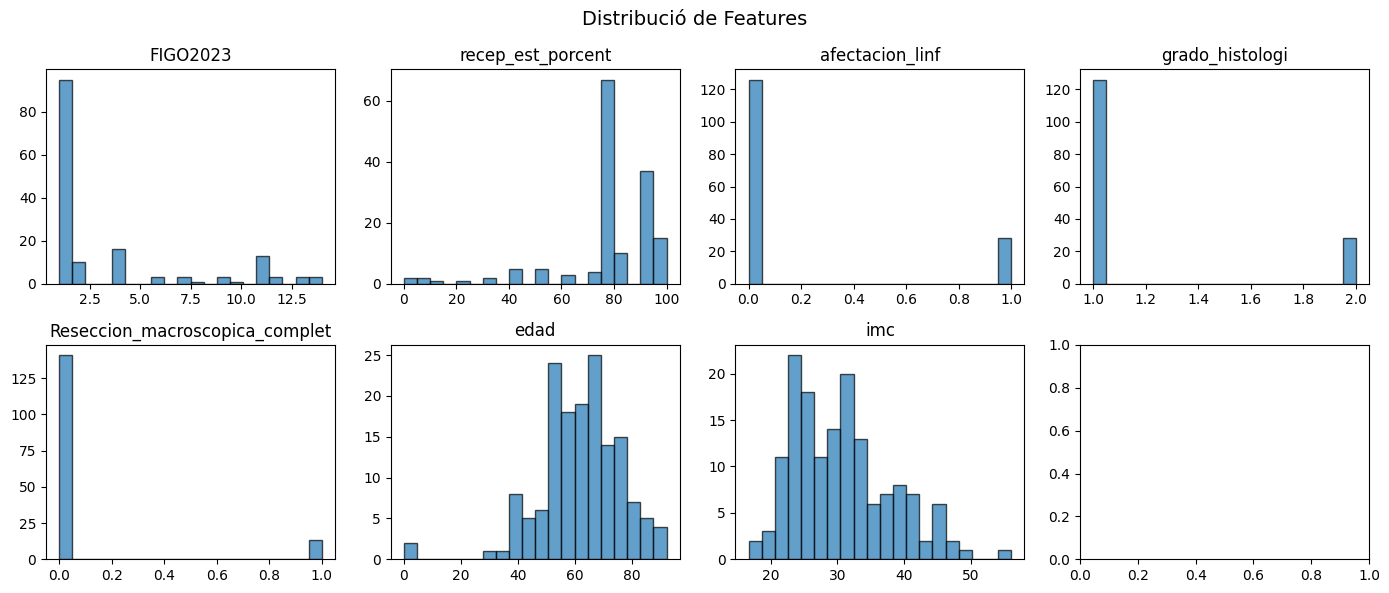

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].hist(X[col].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.suptitle('Distribució de Features', fontsize=14)
plt.tight_layout()
plt.show()

## Next Step
→ Go to `03_model_training.ipynb`